In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder

# Mini EDA

### Observación de los datos

In [260]:
cafe_sales = pd.read_csv("dirty_cafe_sales.csv", header="infer", sep=",")
cafe_sales.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


### Tipos de datos

In [ ]:
tipo_variables = cafe_sales.dtypes
print("Tipos de variables:")
print(tipo_variables)


Tipos de variables:
Transaction ID      object
Item                object
Quantity            object
Price Per Unit      object
Total Spent         object
Payment Method      object
Location            object
Transaction Date    object
dtype: object


### Coregir tipo de datos

In [261]:
cafe_sales["Transaction ID"] = cafe_sales["Transaction ID"].astype(str)
cafe_sales["Item"] = cafe_sales["Item"].astype("category")
cafe_sales["Quantity"] = pd.to_numeric(cafe_sales["Quantity"], errors="coerce")
cafe_sales["Price Per Unit"] = pd.to_numeric(cafe_sales["Price Per Unit"].str.replace(",", ""), errors="coerce")
cafe_sales["Total Spent"] = pd.to_numeric(cafe_sales["Total Spent"].str.replace(",", ""), errors="coerce")
cafe_sales["Payment Method"] = cafe_sales["Payment Method"].astype("category")
cafe_sales["Location"] = cafe_sales["Location"].astype("category")

# Verificar cambios
print(cafe_sales.dtypes)


Transaction ID        object
Item                category
Quantity             float64
Price Per Unit       float64
Total Spent          float64
Payment Method      category
Location            category
Transaction Date      object
dtype: object


### Identificar valores faltantes

In [71]:
cafe_sales.isna().sum()

Transaction ID         0
Item                 333
Quantity             479
Price Per Unit       533
Total Spent          502
Payment Method      2579
Location            3265
Transaction Date     159
dtype: int64

### Información de valores numéricos

In [72]:
print("\nRangos de valores numéricos:")
print(cafe_sales.describe())


Rangos de valores numéricos:
          Quantity  Price Per Unit  Total Spent
count  9521.000000     9467.000000  9498.000000
mean      3.028463        2.949984     8.924352
std       1.419007        1.278450     6.009919
min       1.000000        1.000000     1.000000
25%       2.000000        2.000000     4.000000
50%       3.000000        3.000000     8.000000
75%       4.000000        4.000000    12.000000
max       5.000000        5.000000    25.000000


### Información de las variables categóricas

In [73]:
print("\nCategorías por variable categórica:")
for col in cafe_sales.select_dtypes(include=['category']):
    print(f"{col}: {cafe_sales[col].unique()}")


Categorías por variable categórica:
Item: ['Coffee', 'Cake', 'Cookie', 'Salad', 'Smoothie', ..., 'Sandwich', NaN, 'ERROR', 'Juice', 'Tea']
Length: 11
Categories (10, object): ['Cake', 'Coffee', 'Cookie', 'ERROR', ..., 'Sandwich', 'Smoothie', 'Tea', 'UNKNOWN']
Payment Method: ['Credit Card', 'Cash', 'UNKNOWN', 'Digital Wallet', 'ERROR', NaN]
Categories (5, object): ['Cash', 'Credit Card', 'Digital Wallet', 'ERROR', 'UNKNOWN']
Location: ['Takeaway', 'In-store', 'UNKNOWN', NaN, 'ERROR']
Categories (4, object): ['ERROR', 'In-store', 'Takeaway', 'UNKNOWN']


### Las varaibles catefóricas tenían valores como ERROR y UNKNOWN estas fueron remplazados por N.A

In [262]:
variable_categoricas = cafe_sales.select_dtypes(include=["object", "category"]).columns.tolist()

In [263]:
# Reemplazar "ERROR" y "UNKNOWN" con NaN en esas columnas
cafe_sales[variable_categoricas] = cafe_sales[variable_categoricas].replace(["ERROR", "UNKNOWN"], np.nan)

C:\Users\carol\AppData\Local\Temp\ipykernel_23108\729055680.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  cafe_sales[variable_categoricas] = cafe_sales[variable_categoricas].replace(["ERROR", "UNKNOWN"], np.nan)


### Gráfico sobre los productos vendidos

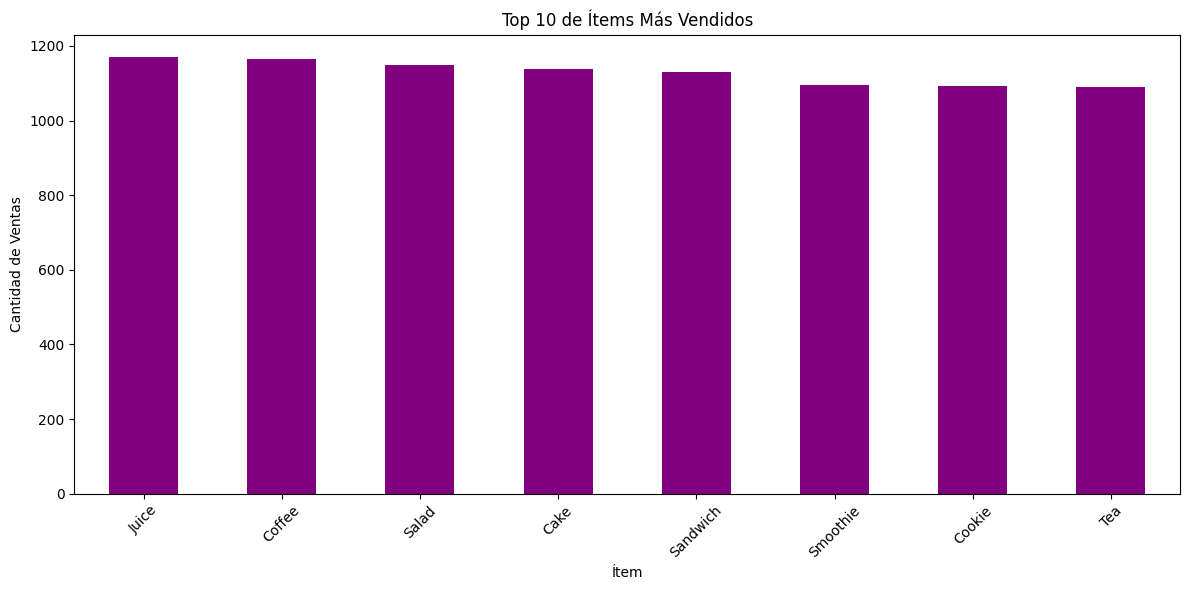

In [ ]:

items_mas_vendidos = cafe_sales["Item"].value_counts().head(10)  

# Crear el gráfico
plt.figure(figsize=(12, 6))
items_mas_vendidos.plot(kind='bar', color='purple') 
plt.title('Top 10 de Ítems Más Vendidos')
plt.xlabel('Ítem')
plt.ylabel('Cantidad de Ventas')
plt.xticks(rotation=45)
plt.tight_layout()  
plt.show()


### Gráfico de pastel sobre los métodos de pago

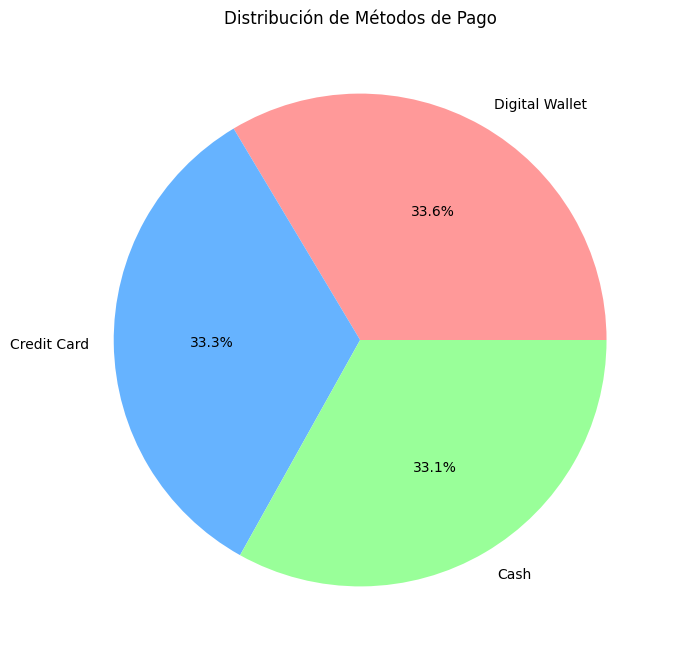

In [77]:
plt.figure(figsize=(8, 8))
cafe_sales["Payment Method"].value_counts().plot(kind="pie", autopct="%1.1f%%", colors=["#ff9999", "#66b3ff", "#99ff99"])
plt.title("Distribución de Métodos de Pago")
plt.ylabel("") 
plt.show()

### Correlación de las variables numéricas

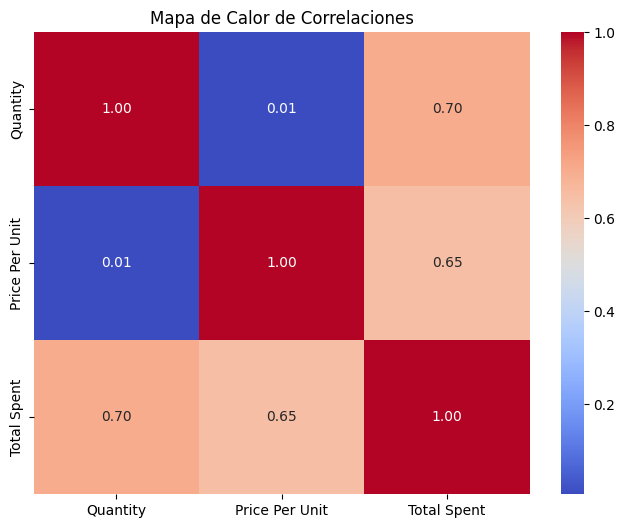

In [78]:
plt.figure(figsize=(8, 6))
sns.heatmap(cafe_sales[["Quantity", "Price Per Unit", "Total Spent"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Mapa de Calor de Correlaciones")
plt.show()


# Pipelines

### Variables numéricas
##### Los valores faltantes en los datos numéricos serán promediados con los demás
###### No se cambiará la escala de los números ya que esto podría dañar la interpretación de los datos, dado que las variables numéricas corresponde a precios y cantidad

In [264]:
categorical_columns = ["Item"] 
onehot_columns = ["Location","Payment Method"]
numerical_columns = ["Quantity", "Price Per Unit", "Total Spent"]

In [265]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="mean"))  
]).set_output(transform="pandas")

display(num_pipeline)

Pipeline(steps=[('imputer', SimpleImputer())])

## Variables categóricas
#### Para las varibles categóricas en los datos faltantes se aplicará la moda
##### Para las varibles categóricas se aplicará la tranfromación 'One Hot Encode' sin embargo esta solo se aplicará a los métodos de pagos y la ubicación de la compra, ya que usarla para la varibale item se construirían demasiadas columnas y esto podría afectar la facil en la interpretación de los datos. Además, para evitar caer en la tampa de las variables binarias, se eliminará la primera columna ya que se sobre entiende que si las filas tienen 0, el 1 le corresponde a la columna faltante; para el caso de la ubicación la columna que esta implicita es 'in store'  y para el caso del método de pago es 'cash'

In [ ]:
cat_pipeline = Pipeline(
[
    ("imputer", SimpleImputer(strategy="most_frequent")) 
]
).set_output(transform="pandas")

display(num_pipeline)

Pipeline(steps=[('imputer', SimpleImputer())])

In [ ]:
onehot_pipeline = Pipeline(
[
    ("imputer", SimpleImputer(strategy="most_frequent")),  
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False, drop="first"))  
]
).set_output(transform="pandas")

display(num_pipeline)

Pipeline(steps=[('imputer', SimpleImputer())])

### fecha

In [268]:
def convert_to_datetime(df):
    df = df.copy()
    df["Transaction Date"] = pd.to_datetime(df["Transaction Date"], errors="coerce")
    return df

In [269]:
date_pipeline = Pipeline([
    ("convert_date", FunctionTransformer(convert_to_datetime))
])

### Full Pipelines

In [270]:
full_pipeline = ColumnTransformer(
    [
        ("num_pipeline", num_pipeline, numerical_columns),  
        ("cat_impute", cat_pipeline, categorical_columns),  
        ("onehot", onehot_pipeline, onehot_columns),  
        ("date_pipeline", date_pipeline, ["Transaction Date"])
    ],
    verbose_feature_names_out=False,  
    remainder="passthrough" 
).set_output(transform="pandas")

display(full_pipeline)

ColumnTransformer(remainder='passthrough',
                  transformers=[('num_pipeline',
                                 Pipeline(steps=[('imputer', SimpleImputer())]),
                                 ['Quantity', 'Price Per Unit', 'Total Spent']),
                                ('cat_impute',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['Item']),
                                ('onehot',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 ['Location', 'Payment Method']),
                                ('date_pipeline',
                                 Pipeline(steps=[('convert_date',
                                                  FunctionTransformer(func=<function convert_to_datetime at 0x000001F49256E980>))]),
                                 ['Transaction Date'])],
                  verbose_feature_names_out=False)

In [271]:
full_pipeline.fit(cafe_sales)
transformacion = full_pipeline.transform(cafe_sales)
transformacion

,Quantity,Price Per Unit,Total Spent,Item,Location_Takeaway,Payment Method_Credit Card,Payment Method_Digital Wallet,Transaction Date,Transaction ID
0,2.0,2.000000,4.000000,Coffee,1.0,1.0,0.0,2023-09-08,TXN_1961373
1,4.0,3.000000,12.000000,Cake,0.0,0.0,0.0,2023-05-16,TXN_4977031
2,4.0,1.000000,8.924352,Cookie,0.0,1.0,0.0,2023-07-19,TXN_4271903
3,2.0,5.000000,10.000000,Salad,1.0,0.0,1.0,2023-04-27,TXN_7034554
4,2.0,2.000000,4.000000,Coffee,0.0,0.0,1.0,2023-06-11,TXN_3160411
...,...,...,...,...,...,...,...,...,...
9995,2.0,2.000000,4.000000,Coffee,1.0,0.0,1.0,2023-08-30,TXN_7672686
9996,3.0,2.949984,3.000000,Juice,1.0,0.0,1.0,2023-06-02,TXN_9659401
9997,4.0,2.000000,8.000000,Coffee,1.0,0.0,1.0,2023-03-02,TXN_5255387
9998,3.0,2.949984,3.000000,Cookie,1.0,0.0,1.0,2023-12-02,TXN_7695629


### Transformación de la fecha

##### Se dividrá la fecha,en años, meses y días

In [272]:
def extract_date_parts(data: pd.DataFrame):
    data["Transaction Date"] = pd.to_datetime(data["Transaction Date"], errors="coerce")
    data["year"] = data["Transaction Date"].dt.year
    data["month"] = data["Transaction Date"].dt.month
    data["day"] = data["Transaction Date"].dt.day
    return data

In [ ]:
date_pipeline = Pipeline([
    ("extract_date", FunctionTransformer(extract_date_parts))  
]).set_output(transform="pandas")


display(date_pipeline)

Pipeline(steps=[('extract_date',
                 FunctionTransformer(func=<function extract_date_parts at 0x000001F492A414E0>))])

#### Se unen los pipelines

In [ ]:
new_full_pipeline = Pipeline([
    ("full_pipeline", full_pipeline),  
    ("date_pipeline", date_pipeline)   
]).set_output(transform="pandas")

display(new_full_pipeline)

Pipeline(steps=[('full_pipeline',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num_pipeline',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer())]),
                                                  ['Quantity', 'Price Per Unit',
                                                   'Total Spent']),
                                                 ('cat_impute',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['Item']),
                                                 ('onehot',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='mo...
                                                                                 sparse_output=False))]),
                                                  ['Location',
                                                   'Payment Method']),
                                                 ('date_pipeline',
                                                  Pipeline(steps=[('convert_date',
                                                                   FunctionTransformer(func=<function convert_to_datetime at 0x000001F49256E980>))]),
                                                  ['Transaction Date'])],
                                   verbose_feature_names_out=False)),
                ('date_pipeline',
                 Pipeline(steps=[('extract_date',
                                  FunctionTransformer(func=<function extract_date_parts at 0x000001F492A414E0>))]))])

In [276]:
transformed = new_full_pipeline.fit_transform(cafe_sales)
transformed

,Quantity,Price Per Unit,Total Spent,Item,Location_Takeaway,Payment Method_Credit Card,Payment Method_Digital Wallet,Transaction Date,Transaction ID,year,month,day
0,2.0,2.000000,4.000000,Coffee,1.0,1.0,0.0,2023-09-08,TXN_1961373,2023.0,9.0,8.0
1,4.0,3.000000,12.000000,Cake,0.0,0.0,0.0,2023-05-16,TXN_4977031,2023.0,5.0,16.0
2,4.0,1.000000,8.924352,Cookie,0.0,1.0,0.0,2023-07-19,TXN_4271903,2023.0,7.0,19.0
3,2.0,5.000000,10.000000,Salad,1.0,0.0,1.0,2023-04-27,TXN_7034554,2023.0,4.0,27.0
4,2.0,2.000000,4.000000,Coffee,0.0,0.0,1.0,2023-06-11,TXN_3160411,2023.0,6.0,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.0,2.000000,4.000000,Coffee,1.0,0.0,1.0,2023-08-30,TXN_7672686,2023.0,8.0,30.0
9996,3.0,2.949984,3.000000,Juice,1.0,0.0,1.0,2023-06-02,TXN_9659401,2023.0,6.0,2.0
9997,4.0,2.000000,8.000000,Coffee,1.0,0.0,1.0,2023-03-02,TXN_5255387,2023.0,3.0,2.0
9998,3.0,2.949984,3.000000,Cookie,1.0,0.0,1.0,2023-12-02,TXN_7695629,2023.0,12.0,2.0
